In [1]:
import pandas as pd

case = '/data/prisoner_datasets/sidoti_june_2023/case2.csv'

df = pd.read_csv(case)

lon_min = df['lon'].min()
lon_max = df['lon'].max()

lat_min = df['lat'].min()
lat_max = df['lat'].max()

# print(df)

# get the first few rows of the data and turn to numpy array
obs = df.to_numpy()

# obs = obs[obs[:, 3] == 85]
print(obs)

# max_track = max(obs[:, 3])
# print(max_track)

# print(obs_two)

              lon       lat            dt  track
0      278.663456 -1.007864  2.016063e+13    0.0
1      278.591578 -0.976595  2.016063e+13    0.0
2      278.521809 -0.940576  2.016063e+13    0.0
3      278.450292 -0.909849  2.016063e+13    0.0
4      278.378039 -0.876198  2.016063e+13    0.0
...           ...       ...           ...    ...
33850  274.680356 -1.674666  2.016063e+13  511.0
33851  274.610243 -1.656992  2.016063e+13  511.0
33852  274.543997 -1.643051  2.016063e+13  511.0
33853  274.477296 -1.627824  2.016063e+13  511.0
33854  274.417306 -1.614921  2.016063e+13  511.0

[33855 rows x 4 columns]
[[ 2.78663456e+02 -1.00786431e+00  2.01606251e+13  0.00000000e+00]
 [ 2.78591578e+02 -9.76595296e-01  2.01606251e+13  0.00000000e+00]
 [ 2.78521809e+02 -9.40575886e-01  2.01606251e+13  0.00000000e+00]
 ...
 [ 2.74543997e+02 -1.64305072e+00  2.01606262e+13  5.11000000e+02]
 [ 2.74477296e+02 -1.62782432e+00  2.01606262e+13  5.11000000e+02]
 [ 2.74417306e+02 -1.61492106e+00  2.01606270e

In [2]:
import os
import numpy as np

def select_random_rows(array, n):
    b, m = array.shape

    if n >= b:
        return array

    indices = np.arange(b)
    np.random.shuffle(indices)

    selected_indices = indices[:n]
    remaining_indices = indices[n:]

    selected_rows = np.full((n, m), -np.inf)
    selected_rows[:len(selected_indices)] = array[selected_indices]

    result = np.copy(array)
    result[remaining_indices] = -np.inf

    return result

In [6]:
import numpy as np
import os
import pandas as pd
filepath = '/data/prisoner_datasets/sidoti_june_2023/'
# list files in folder
files = os.listdir(filepath)

o = []

lon_min = np.inf
lon_max = -np.inf

lat_min = np.inf
lat_max = -np.inf

j = 0
for file in files:
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(filepath, file))

        lon_min = min(df['lon'].min(), lon_min)
        lon_max = max(df['lon'].max(), lon_max)

        lat_min = min(df['lat'].min(), lat_min)
        lat_max = max(df['lat'].max(), lat_max)

        o.append(df.to_numpy())

print(lon_min, lon_max)
print(lat_min, lat_max)

obs = np.concatenate(o, axis=0)

265.0493490912737 278.664288606377
-6.652955916615507 0.6115757364255072
265.0493490912737 279.6740834772055
-6.652955916615507 9.215063787546448
265.0493490912737 281.4743167488036
-6.652955916615507 9.215063787546448
265.0493490912737 281.4743167488036
-6.652955916615507 9.215063787546448


In [5]:
import os
import numpy as np
import pandas as pd

filepath = '/data/prisoner_datasets/sidoti_june_2023/'
# list files in folder
files = os.listdir(filepath)

train_test_split = 0.85
percent = 0.10
j = 0
for file in sorted(files):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(filepath, file))
        obs = df.to_numpy()
        max_track = max(obs[:, 3])
        for i in range(0, int(max_track)):
            j += 1
            o = obs[obs[:, 3] == i]
            if len(o) == 0:
                continue
            dones = np.full(o.shape[0], False)
            dones[-1] = True

            # b = (o[:, 2] - o[0, 2])
            red_locations = o[:, 0:2]
            num_detects = percent * len(red_locations)
            detects = select_random_rows(red_locations, 10)

            # need to split each file in the csv equally between train and test
            if i < train_test_split * max_track:
                np.savez(f'/data/prisoner_datasets/sidoti/train/track_{j}', 
                         red_locations = red_locations,
                         detected_locations = detects,
                         dones = dones)
            else:
                np.savez(f'/data/prisoner_datasets/sidoti/test/track_{j}', 
                        red_locations = red_locations,
                        detected_locations = detects,
                        dones = dones)


Text(0.5, 1.0, 'test')

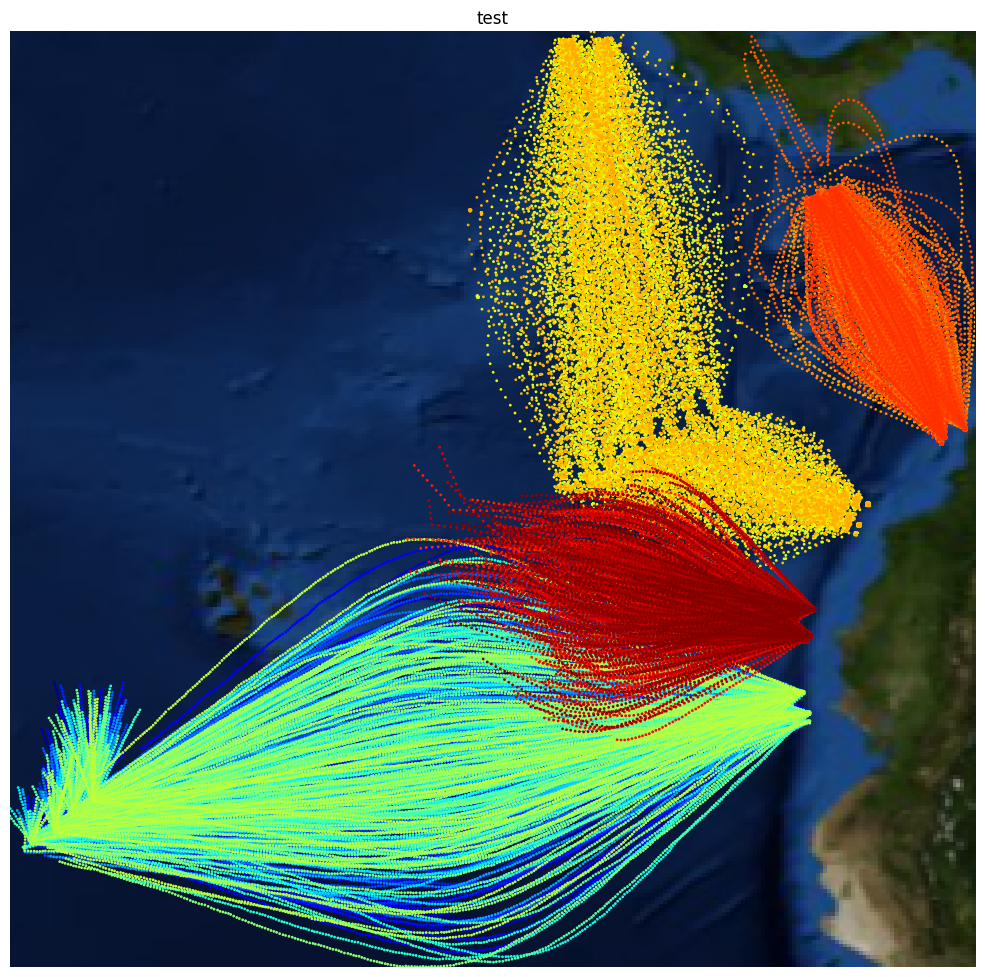

In [25]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

plt.clf()
fig = plt.gcf()
fig.set_size_inches(10, 10)

path_length = len(obs)

show_type = 'flat'
if show_type == 'flat':
# create map using BASEMAP
    m = Basemap(
                llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max-lon_min)/2,
                projection='merc',
                # projection='aeqd',
                resolution = None,
                area_thresh=10000.,
                )
else:
    width = 28000000
    m = Basemap(
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max-lon_min)/2,
                projection='aeqd',
                width = width,
                height = width, 
                )
m.bluemarble()

size = 1
colors = plt.cm.jet(np.linspace(0,1,path_length))

# lon, lat
x, y = m(obs[:, 0], obs[:, 1])
# m.plot(x, y, marker='.', linestyle='', s=1, markersize=size, c='grey', label='Path')
m.scatter(x, y, s=size, c=colors, marker='o', label='Path')

#tight layout
plt.tight_layout()

plt.axis('off')
plt.title('test')

In [3]:
import numpy as np
a = np.load('/data/prisoner_datasets/october_datasets/4_detect/test/seed_0_known_44_unknown_33.npz', allow_pickle=True)
for k in a.keys():
    print(k)
a['hideout_observations']
a['detected_locations']
print(a['timestep_observations'].shape)

# print(-np.inf * 2428 + 100)


blue_observations
red_observations
agent_observations
hideout_observations
timestep_observations
detected_locations
red_locations
dones
agent_dict
detect
last_k_fugitive_detections
last_k_fugitive_velocities
blue_obs_dict
prediction_obs_dict
(368, 1)
